In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
dat = pd.read_csv('data/01_standard_practice.csv')

x = dat['x']
y = dat['y']
sig_y = dat['sig_y']

In [3]:
import decimal

def linear(x, params):
    return params[0] * x + params[1]

def gaussian(y, sigma, mu):
    return ((1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp( -(y - mu)**2 / (2 * sigma**2) ))

def likelihood(func, x, y, sig_y, params):
    '''
    Inputs:    
        y   - the dependent variable array of observed measurements
        m   - slope
        b   - intercept
        P_b - Probability of a bad point
        Y_b - mean of distribution of bad points
        V_b - variance of distribution of bad points
        sig_y - variance in y space
        
    Outputs:
        likelihood = p({y_i} | m, b, P_b, Y_b, V_b, I)
    '''
    
    m = params[0]
    b = params[1]
    P_b = params[2]
    Y_b = params[3]
    V_b = params[4]
    
    likelihood = 1
    
    for i in range(len(x)):        
        foreground = gaussian(y[i], sig_y[i], func(x[i], [m, b]))
        background = gaussian(y[i], np.sqrt(V_b + sig_y[i]**2), Y_b)
        #print(((1 - P_b) * foreground) + ((P_b) * background))
        
        likelihood *= ((1 - P_b) * foreground) + ((P_b) * background)
        
    return likelihood

In [4]:
import random

def metropolis_hastings(kernel, func, x, y, sig_y, params, steps = 5000, stepsize = 0.001):
    param_set = []
    
    param_array = []
    param_ub = []
    param_lb = []
        
    '''
    
    Initialize chain
    
    '''
        
    for key in params.keys():
        param_array.append(params[key][0])
        param_ub.append(params[key][1])
        param_lb.append(params[key][2])
        
    param_set.append([kernel(func, x, y, sig_y, param_array), np.array(param_array)])
    
    '''
    
    Start stepping
    
    '''
    
    for i in tqdm(range(steps)):
        prev_param_array = param_array
        prev_likelihood = param_set[-1][0]
        
        for j in range(len(param_array)):
            newparam = random.gauss(prev_param_array[j], stepsize)
            #newparam = random.uniform(param_lb[j], param_ub[j])
            
            param_array[j] = newparam
            
        likelihood = kernel(func, x, y, sig_y, param_array)
        R = random.uniform(0, 1)
        
        if R < (likelihood / prev_likelihood):
            param_set.append(np.array([likelihood, np.array(param_array)]))
        else:
            param_set.append(np.array([prev_likelihood, np.array(prev_param_array)]))              
    
    return np.array(param_set)
        
params = {'m' : np.array([2, 0, 5]),
            'b' : np.array([30, 20, 40]),
            'P_b' : np.array([0.1, 0, 1]),
            'Y_b' : np.array([0, -100, 100]),
            'V_b' : np.array([10, -100, 100])}

param_set = metropolis_hastings(likelihood, linear, x, y, sig_y, params, steps = 5000, stepsize = 0.001)


  0%|                                                                                  | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_13642/401765718.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  param_set.append(np.array([likelihood, np.array(param_array)]))
/tmp/ipykernel_13642/401765718.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  param_set.append(np.array([prev_likelihood, np.array(prev_param_array)]))
100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1161.68it/s]
/tmp/ipykernel_13642/401765

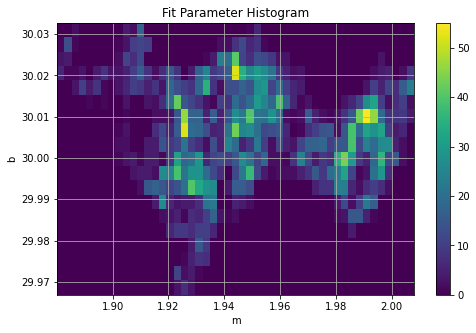

In [5]:
likelihoods = (param_set.T[0])
m = ([param_set.T[1][i][0] for i in range(len(param_set.T[1]))])
b = [param_set.T[1][i][1] for i in range(len(param_set.T[1]))]

x_min = min(m)
x_max = max(m)

y_min = min(b)
y_max = max(b)

x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 20)

plt.figure(figsize=(8,5))

#color = plt.cm.coolwarm(likelihoods)

#plt.plot(m, b, alpha = 0.5)
plt.hist2d(m, b, bins =[x_bins, y_bins])
plt.title("Fit Parameter Histogram")
plt.xlabel('m')
plt.ylabel('b')
plt.grid()
plt.colorbar()


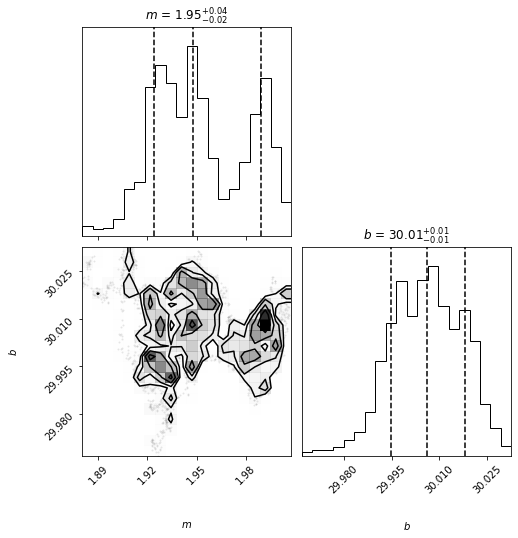

In [6]:
import corner
import numpy as np

samples = np.array([m,b]).T
figure = corner.corner(samples, labels=[r"$m$", r"$b$"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
figure.set_size_inches(8,8)

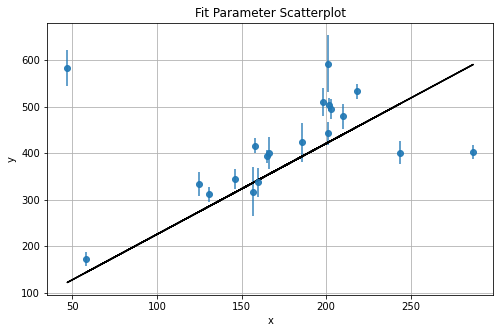

In [7]:
mval = np.mean(m)
bval = np.mean(b)

plt.figure(figsize=(8,5))

plt.errorbar(x, y, yerr = sig_y, alpha = 0.9, fmt = 'o')

plt.plot(x, linear(x, [mval, bval]), color = 'black')

plt.title("Fit Parameter Scatterplot")
plt.xlabel('x')
plt.ylabel('y')
plt.grid()


  0%|                                                                                  | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_13642/401765718.py:42: RuntimeWarning: invalid value encountered in double_scalars
  if R < (likelihood / prev_likelihood):
/tmp/ipykernel_13642/401765718.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  param_set.append(np.array([prev_likelihood, np.array(prev_param_array)]))
100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1271.22it/s]
/tmp/ipykernel_13642/401765718.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

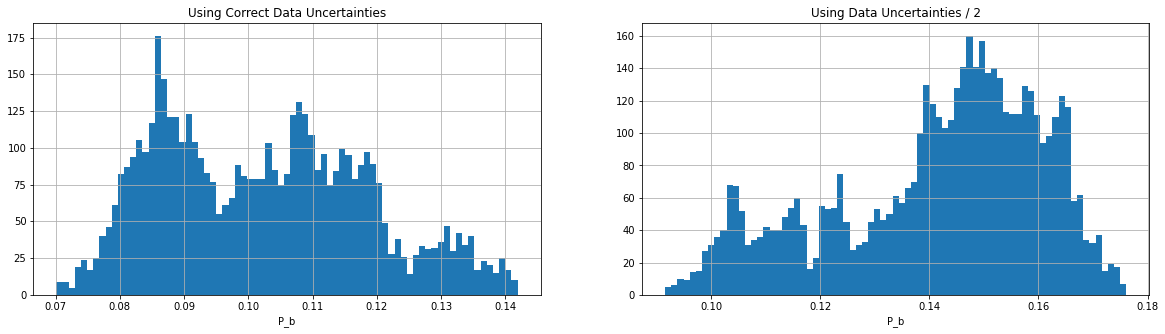

In [8]:
P_b = [param_set.T[1][i][2] for i in range(len(param_set.T[1]))]

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.hist(P_b, bins = 75)
plt.title("Using Correct Data Uncertainties")
plt.xlabel('P_b')
plt.grid()

param_set = metropolis_hastings(likelihood, linear, x, y, sig_y / 2, params, steps = 5000, stepsize = 0.001)
P_b = [param_set.T[1][i][2] for i in range(len(param_set.T[1]))]

plt.subplot(1, 2, 2)
plt.hist(P_b, bins = 75)
plt.title("Using Data Uncertainties / 2")
plt.xlabel('P_b')
plt.grid()